## Import Data ##

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from scipy.stats import *
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [230]:
df = pd.read_csv("/Users/jay/Jupyter Projects/Animals/labels.csv")
df

,image_name,category
0,beetle/687486f1cb.jpg,Tiny Survivors
1,beetle/93fb82b04b.jpg,Tiny Survivors
2,beetle/7d7f6c9750.jpg,Tiny Survivors
3,beetle/0de750893f.jpg,Tiny Survivors
4,beetle/2fecd5e844.jpg,Tiny Survivors
...,...,...
5395,boar/51c7d65b34.jpg,Other
5396,boar/981d244af2.jpg,Other
5397,boar/287ebb3999.jpg,Other
5398,boar/5d00af3e3f.jpg,Other


In [232]:
df["image_name"] = "/Users/jay/Jupyter Projects/Animals/animals/animals/animals/" + df["image_name"]
df["image_name"].iloc[1]

'/Users/jay/Jupyter Projects/Animals/animals/animals/animals/beetle/93fb82b04b.jpg'

## Statistical Modeling ##

Shape:  (5400, 2)

Counts:
 category
Other                                1920
Tiny Survivors                        540
Stealth & Shadows                     480
Apex Predators                        420
Flight Masters                        420
Underwater Specialists                420
Tough Defenders                       360
Survival Geniuses                     300
Speed Demons                          300
Cold-Climate Survivors                180
Pack Hunters & Social Strategists      60
Name: count, dtype: int64



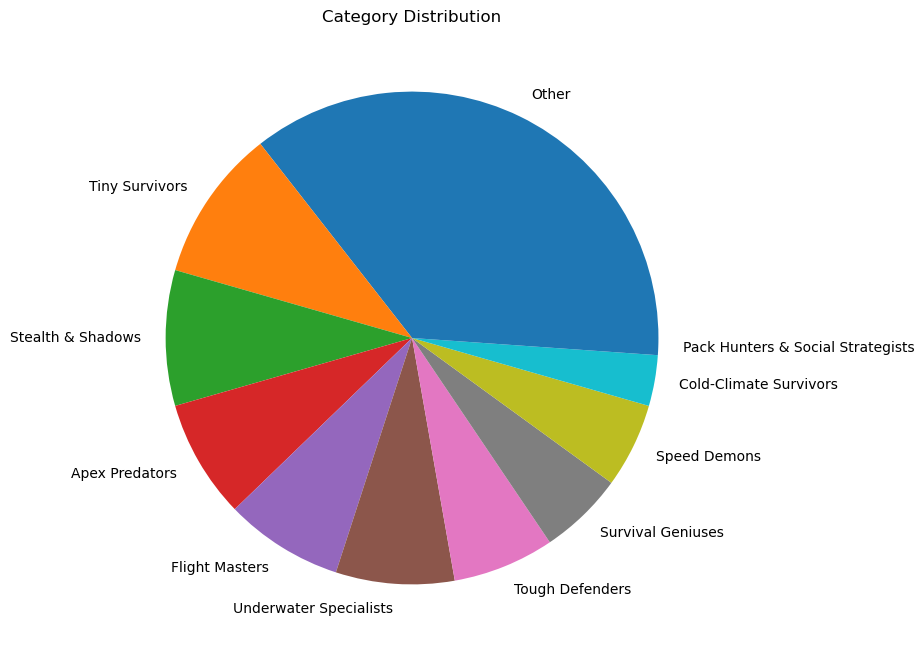

In [238]:
print("Shape: ", df.shape)
print("\nCounts:\n", df["category"].value_counts())

print()

plt.figure(figsize=(10,8))
plt.pie(df["category"].value_counts(), labels = df["category"].value_counts().index)
plt.title("Category Distribution")
plt.show()

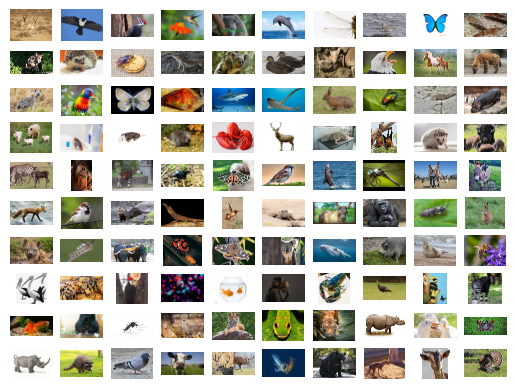

In [242]:
#100 random images
n_rows = 10
n_cols = 10

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(df.sample(n=1)["image_name"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")

plt.show()

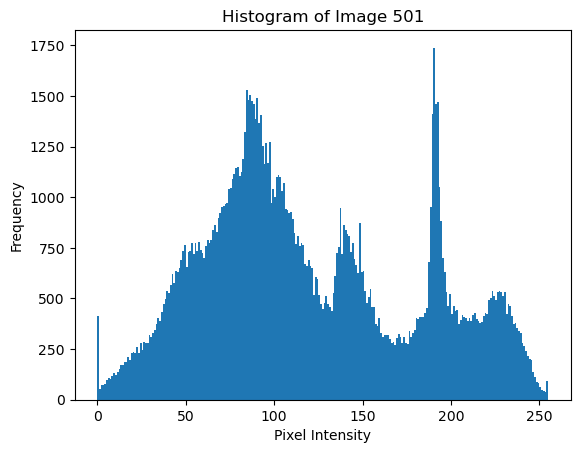

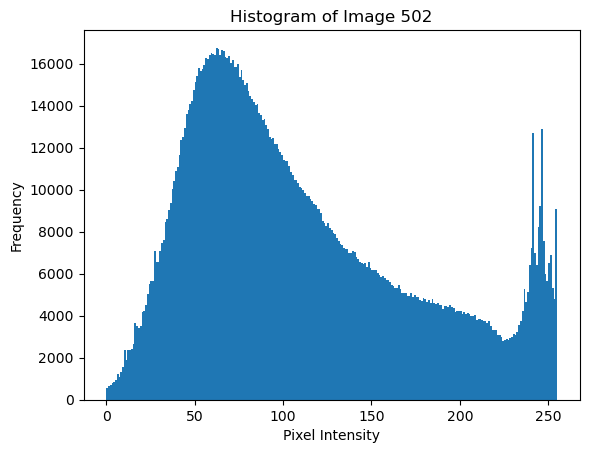

In [316]:
for i in range(500, 502):
    plt.figure()
    
    img_data = np.array(Image.open(df.iloc[i, 0])).ravel()
    
    plt.hist(img_data, bins=range(256))
    
    plt.title(f"Histogram of Image {i+1}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.show()

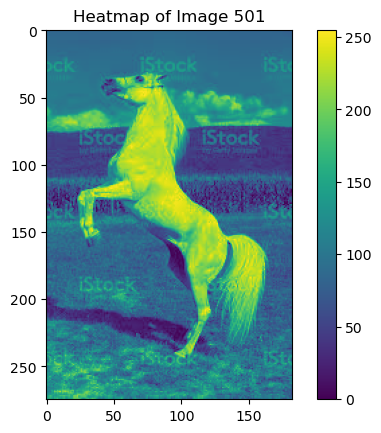

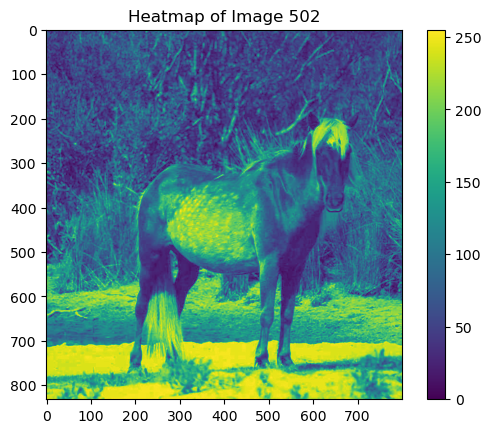

In [318]:
for i in range(500, 502):
    plt.figure()

    img_data = np.array(Image.open(df.iloc[i, 0]))

    cax = plt.imshow(img_data, cmap="viridis", interpolation="nearest")

    plt.title(f"Heatmap of Image {i+1}")

    plt.colorbar(cax)

    plt.imshow(img_data[:, :, 0])

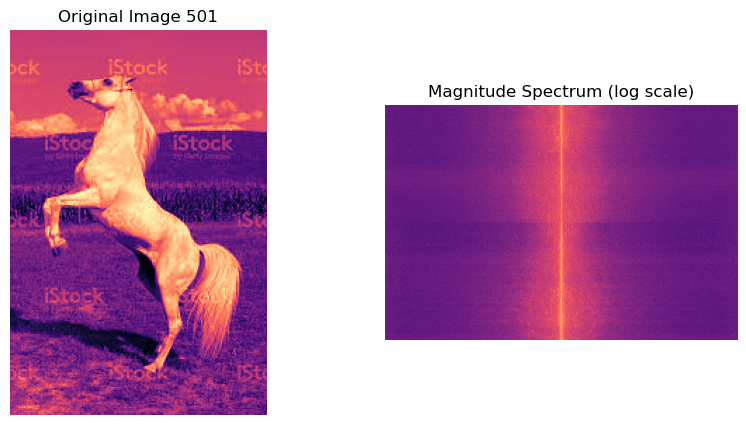

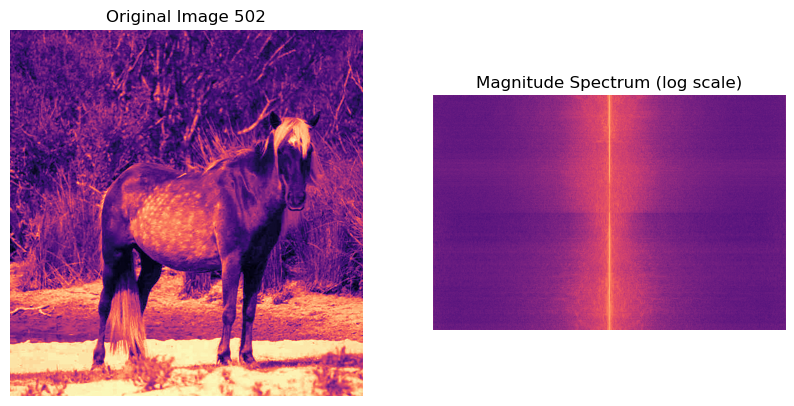

In [320]:
for i in range(500, 502):
    img_data = plt.imread(df.iloc[0+i, 0])
    
    if len(img_data.shape) == 3:
        img_data = np.mean(img_data, axis=2)
    
    ft = np.fft.fft2(image)
    
    ft_shifted = np.fft.fftshift(ft)
    
    magnitude_spectrum = np.abs(ft_shifted)
    
    magnitude_spectrum_log = np.log1p(magnitude_spectrum)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_data, cmap="magma")
    plt.title(f"Original Image {i+1}")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum_log[:, :, 0], cmap="magma")
    plt.title("Magnitude Spectrum (log scale)")
    plt.axis("off")
    
    plt.show()

## Training Model ##

In [322]:
train = df.sample(frac = 0.7)
test = df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(3780, 2)
(810, 2)
(810, 2)


In [324]:
le = LabelEncoder()
le.fit(df["category"])

transform = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [326]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(le.transform(dataframe["category"])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [328]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)

In [455]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 15

In [457]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [459]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(128, 512, kernel_size = 3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((512*8*8), 512)

        self.output = nn.Linear(512, len(df["category"].unique()))

    def forward(self, x):
        x = self.conv1(x) #(32, 128, 128)
        x = self.pooling(x) #(32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x) #(64, 64, 64)
        x = self.pooling(x) #(64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x) #(128, 32, 32)
        x = self.pooling(x) #(128, 16, 16)
        x = self.relu(x)

        x = self.conv4(x) #(512, 16, 16)
        x = self.pooling(x) #(512, 8, 8) same as number in self.linear
        x = self.relu(x)
        
        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

In [461]:
model = Net().to(device)

In [463]:
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            590,336
├─MaxPool2d: 1-5                         --
├─ReLU: 1-6                              --
├─Flatten: 1-7                           --
├─Linear: 1-8                            16,777,728
├─Linear: 1-9                            5,643
Total params: 17,466,955
Trainable params: 17,466,955
Non-trainable params: 0

In [465]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [467]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/val_dataset.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1}/{EPOCHS} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/val_dataset.__len__()*100, 4)}''')

    print("="*50)

Epoch no. 1/15 
    Training Loss: 0.4815 
    Training Accuracy: 37.0106 
    Validation Loss: 0.102 
    Validation Accuracy: 37.1605
Epoch no. 2/15 
    Training Loss: 0.4544 
    Training Accuracy: 39.0476 
    Validation Loss: 0.1 
    Validation Accuracy: 37.9012
Epoch no. 3/15 
    Training Loss: 0.4337 
    Training Accuracy: 40.0794 
    Validation Loss: 0.0944 
    Validation Accuracy: 39.2593
Epoch no. 4/15 
    Training Loss: 0.4149 
    Training Accuracy: 41.9048 
    Validation Loss: 0.0932 
    Validation Accuracy: 39.0123
Epoch no. 5/15 
    Training Loss: 0.3918 
    Training Accuracy: 45.0794 
    Validation Loss: 0.0891 
    Validation Accuracy: 41.4815
Epoch no. 6/15 
    Training Loss: 0.3652 
    Training Accuracy: 47.963 
    Validation Loss: 0.0869 
    Validation Accuracy: 42.963
Epoch no. 7/15 
    Training Loss: 0.3299 
    Training Accuracy: 53.1481 
    Validation Loss: 0.0872 
    Validation Accuracy: 44.5679
Epoch no. 8/15 
    Training Loss: 0.2933 
    

In [469]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)
        
        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc
        
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f'''Accuracy Score: {round((total_acc_test/test_dataset.__len__())*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 50.9877 
Loss: 0.1461


## Post-Training Analysis ##

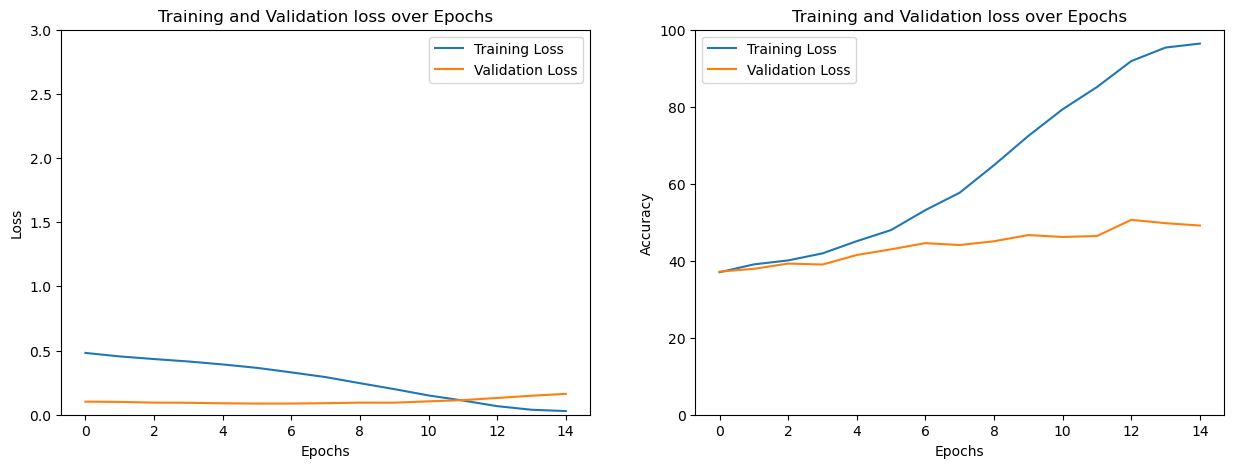

In [471]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,3])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [473]:
torch.save(model.state_dict(), "Animals.pth")

In [475]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load("Animals.pth"))
loaded_model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=32768, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=11, bias=True)
)

In [477]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)
    
    model_prediction = loaded_model(image.unsqueeze(0))
    model_prediction = torch.argmax(model_prediction, axis = 1).item()
    
    return le.inverse_transform([model_prediction])

['Tiny Survivors']


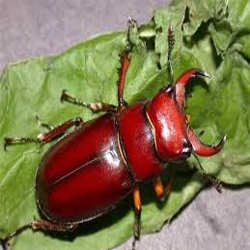

In [513]:
path1 = "/Users/jay/Jupyter Projects/Animals/beetle.jpeg"
print(predict_image(path1))
Image.open(path1).convert("RGB").resize([250, 250])

['Tiny Survivors']


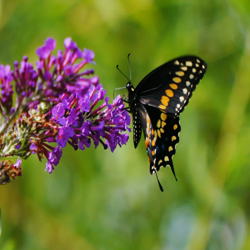

In [521]:
path2 = "/Users/jay/Jupyter Projects/Animals/Butterfly.webp"
print(predict_image(path2))
Image.open(path2).convert("RGB").resize([250, 250])

['Apex Predators']


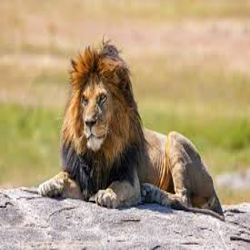

In [517]:
path3 = "/Users/jay/Jupyter Projects/Animals/lion.jpeg"
print(predict_image(path3))
Image.open(path3).convert("RGB").resize([250, 250])

['Underwater Specialists']


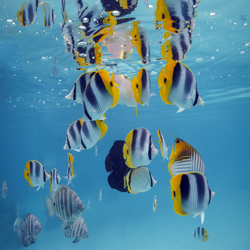

In [519]:
path3 = "/Users/jay/Jupyter Projects/Animals/fish.jpg"
print(predict_image(path3))
Image.open(path3).convert("RGB").resize([250, 250])